In [2]:
import os
import pandas as pd
import numpy as np

import re
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

import spacy
nlp = spacy.load("en_core_web_sm")  # For named entity recognition (NER)

from textblob import TextBlob  # For sentiment analysis

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nizar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:


def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs and emails
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', ' ', text)
    # Remove punctuation and digits
    text = re.sub(f'[{re.escape(string.punctuation)}0-9]', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [3]:
from google.colab import drive
drive.mount('/content/drive')

dataset_dir = "/content/drive/MyDrive/archive"

texts = []
labels = []

for filename in os.listdir(dataset_dir):
    if filename.endswith('.csv') and filename != 'phishing_email.csv':
        print(f"Loading: {filename}")
        df = pd.read_csv(os.path.join(dataset_dir, filename)).dropna(subset=['body', 'label'])
        texts += df['body'].tolist()
        labels += df['label'].tolist()

# Iterate through CSV files (skip phishing_email.csv if needed)
for filename in os.listdir(dataset_dir):
    if filename.endswith('.csv') and filename != 'phishing_email.csv':
        print(f"Loading: {filename}")
        df = pd.read_csv(os.path.join(dataset_dir, filename)).dropna(subset=['body', 'label'])
        texts += df['body'].tolist()
        labels += df['label'].tolist()

# Convert to DataFrame for easier analysis
df_emails = pd.DataFrame({'body': texts, 'label': labels})

# --- Clean the email texts ---
df_emails['clean_body'] = df_emails['body'].apply(clean_text)

# --- Basic EDA ---
# 1. Class distribution
print("Class distribution:")
print(df_emails['label'].value_counts())

# 2. Email length statistics
df_emails['word_count'] = df_emails['clean_body'].apply(lambda x: len(x.split()))
df_emails['char_count'] = df_emails['clean_body'].apply(len)

print("\nEmail length statistics by class:")
print(df_emails.groupby('label')[['word_count', 'char_count']].describe())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading: Ling.csv
Loading: CEAS_08.csv
Loading: Nigerian_Fraud.csv
Loading: Nazario.csv
Loading: Enron.csv
Loading: SpamAssasin.csv
Loading: Ling.csv
Loading: CEAS_08.csv
Loading: Nigerian_Fraud.csv
Loading: Nazario.csv
Loading: Enron.csv
Loading: SpamAssasin.csv
Class distribution:
label
1    85780
0    79190
Name: count, dtype: int64

Email length statistics by class:
      word_count                                                              \
           count        mean          std  min   25%    50%    75%       max   
label                                                                          
0        79190.0  294.946635   724.411681  0.0  72.0  152.0  302.0   35004.0   
1        85780.0  181.768011  3181.710902  0.0  31.0   68.0  217.0  654202.0   

      char_count                                                         \
           count      

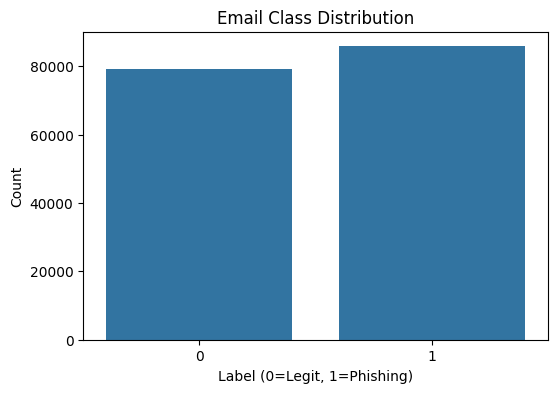

In [12]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df_emails)
plt.title("Email Class Distribution")
plt.xlabel("Label (0=Legit, 1=Phishing)")
plt.ylabel("Count")
plt.show()


In [15]:
top_phishing_words = pd.DataFrame(get_top_words(phishing_texts), columns=['Word', 'Count'])
top_legit_words = pd.DataFrame(get_top_words(legit_texts), columns=['Word', 'Count'])

print("Top Phishing Words:\n", top_phishing_words.head(10))
print("Top Legitimate Words:\n", top_legit_words.head(10))


Top Phishing Words:
       Word  Count
0      com  54436
1        e  52540
2    email  45276
3      cnn  42976
4        b  37724
5        c  37342
6  company  37136
7   please  36288
8    money  35314
9      top  34168
Top Legitimate Words:
          Word   Count
0  submission  106464
1       enron  105722
2          id   79944
3         ect   69432
4       would   50824
5         new   48430
6           e   44544
7      please   44018
8         com   43658
9         one   42480


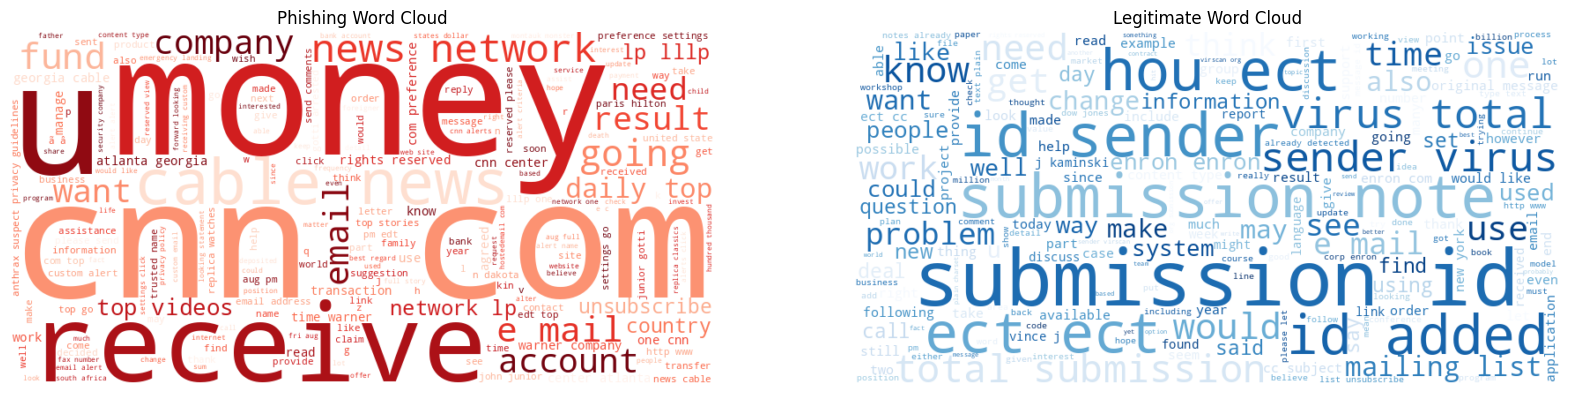

In [16]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(phishing_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Phishing Word Cloud")

plt.subplot(1,2,2)
plt.imshow(legit_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Legitimate Word Cloud")
plt.show()


In [17]:
top_phishing_bigrams_df = pd.DataFrame(top_phishing_bigrams, columns=['Bigram', 'Count'])
top_legit_bigrams_df = pd.DataFrame(top_legit_bigrams, columns=['Bigram', 'Count'])

print("Top Phishing Bigrams:\n", top_phishing_bigrams_df.head(10))
print("Top Legitimate Bigrams:\n", top_legit_bigrams_df.head(10))


Top Phishing Bigrams:
             Bigram  Count
0          cnn com  23238
1       cable news  17356
2     news network  17348
3        daily top  11722
4       top videos  11720
5       network lp  11720
6          lp lllp  11720
7  rights reserved  10052
8    receive email   9016
9   company rights   8702
Top Legitimate Bigrams:
              Bigram  Count
0     submission id  64492
1         id sender  35554
2  submission notes  35290
3           hou ect  31858
4  added submission  31164
5           ect ect  30988
6          id added  28980
7  notes submission  28966
8      sender virus  28230
9       virus total  28230


/tmp/ipython-input-1106459832.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Bigram', data=top_phishing_bigrams_df.head(10), palette='Reds')


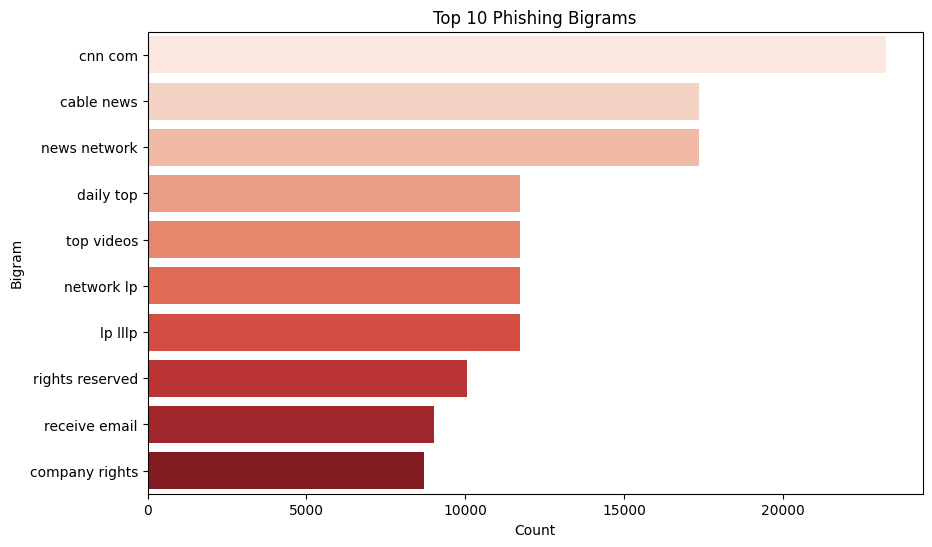

/tmp/ipython-input-1106459832.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Bigram', data=top_legit_bigrams_df.head(10), palette='Blues')


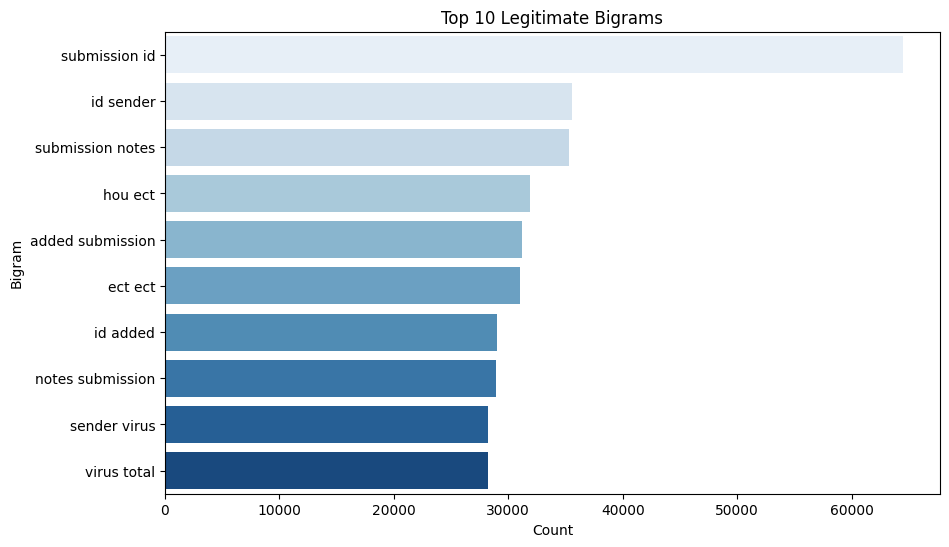

In [18]:
plt.figure(figsize=(10,6))
sns.barplot(x='Count', y='Bigram', data=top_phishing_bigrams_df.head(10), palette='Reds')
plt.title("Top 10 Phishing Bigrams")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x='Count', y='Bigram', data=top_legit_bigrams_df.head(10), palette='Blues')
plt.title("Top 10 Legitimate Bigrams")
plt.show()


In [23]:
# Make sure spaCy is loaded
import spacy
nlp = spacy.load("en_core_web_sm")

from collections import Counter

def extract_entities(texts, entity_types=None):
    """
    Extract entities from a list of texts and count frequency.
    entity_types: list of spaCy entity labels to filter, e.g., ['ORG']
    """
    entity_counter = Counter()
    for text in texts:
        doc = nlp(text)
        for ent in doc.ents:
            if entity_types is None or ent.label_ in entity_types:
                entity_counter[ent.text] += 1
    return entity_counter

phishing_texts = df_emails[df_emails['label']==1]['clean_body']
legit_texts = df_emails[df_emails['label']==0]['clean_body']

sample_size = 500  # Adjust as needed
phishing_texts_sample = phishing_texts.sample(n=min(sample_size, len(phishing_texts)), random_state=42)
legit_texts_sample = legit_texts.sample(n=min(sample_size, len(legit_texts)), random_state=42)

# Extract top organizations
phishing_orgs = extract_entities(phishing_texts_sample, entity_types=['ORG'])
legit_orgs = extract_entities(legit_texts_sample, entity_types=['ORG'])

top_phishing_orgs_df = pd.DataFrame(phishing_orgs.most_common(10), columns=['Organization', 'Count'])
top_legit_orgs_df = pd.DataFrame(legit_orgs.most_common(10), columns=['Organization', 'Count'])

print("Top Phishing Organizations (Sample):\n", top_phishing_orgs_df)
print("Top Legitimate Organizations (Sample):\n", top_legit_orgs_df)


Top Phishing Organizations (Sample):
          Organization  Count
0                 cnn    199
1              warner     43
2  georgia cable news     25
3           microsoft     18
4                  un     13
5        paris hilton     11
6               yahoo     10
7                  ge      9
8              google      8
9         jeanne moos      7
Top Legitimate Organizations (Sample):
   Organization  Count
0        yahoo     27
1                 25
2          doc     25
3    microsoft     20
4     cmdrtaco     13
5      el paso     11
6           un     10
7     stanford      9
8          ibm      9
9       senate      9


/tmp/ipython-input-3702676883.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Organization', data=top_phishing_orgs_df, palette='Reds')


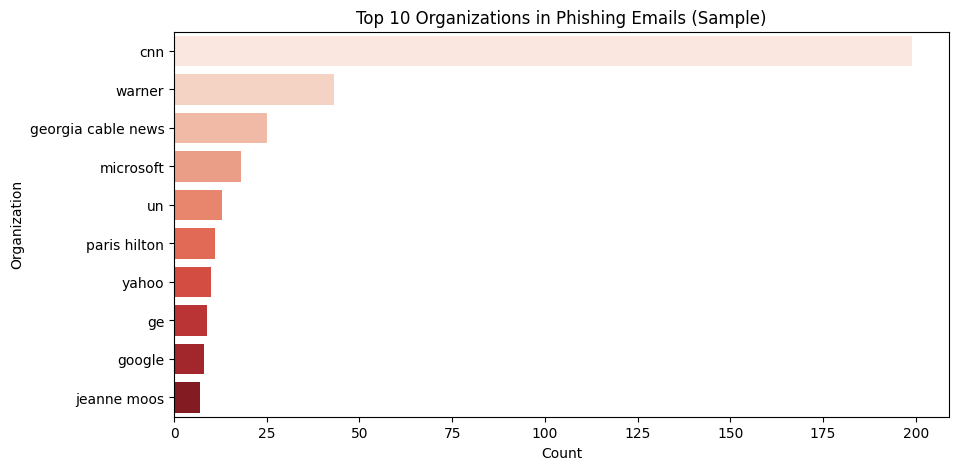

In [24]:
plt.figure(figsize=(10,5))
sns.barplot(x='Count', y='Organization', data=top_phishing_orgs_df, palette='Reds')
plt.title("Top 10 Organizations in Phishing Emails (Sample)")
plt.show()

/tmp/ipython-input-505744177.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Organization', data=top_legit_orgs_df, palette='Blues')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


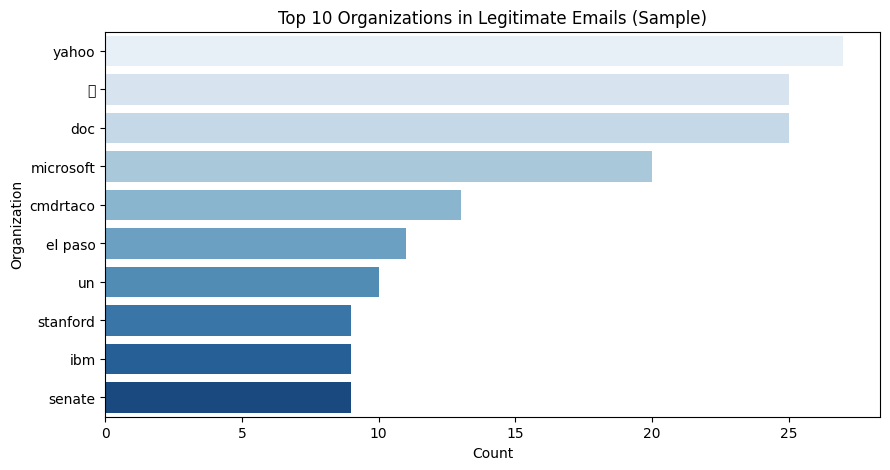

In [25]:
plt.figure(figsize=(10,5))
sns.barplot(x='Count', y='Organization', data=top_legit_orgs_df, palette='Blues')
plt.title("Top 10 Organizations in Legitimate Emails (Sample)")
plt.show()

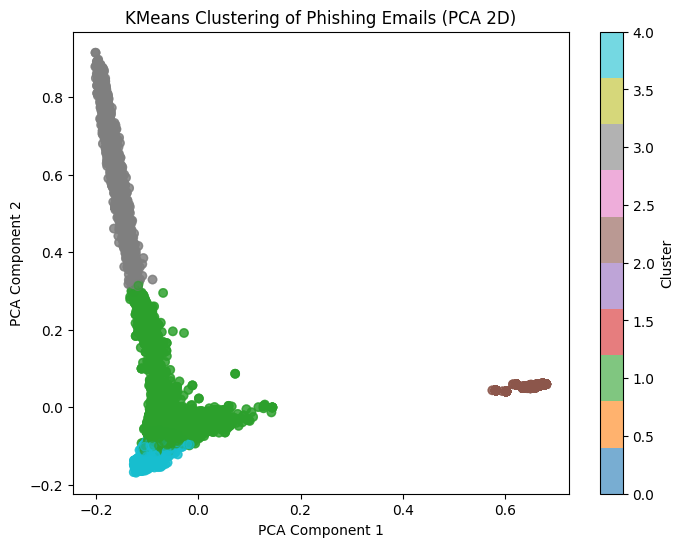

In [27]:
# --- Use only phishing emails for clustering example ---
texts_to_cluster = df_emails[df_emails['label']==1]['clean_body']

# --- TF-IDF Vectorization ---
vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
X = vectorizer.fit_transform(texts_to_cluster)

# --- KMeans Clustering ---
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_

# --- PCA for visualization ---
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())  # This defines X_pca

# --- Scatter plot ---
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='tab10', alpha=0.6)
plt.title("KMeans Clustering of Phishing Emails (PCA 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.show()

In [30]:
# --- Sample phishing emails (optional, limits runtime) ---
sample_size = 500
texts_to_cluster = df_emails[df_emails['label']==1]['clean_body'].sample(n=min(sample_size, len(df_emails[df_emails['label']==1])), random_state=42)

# --- Vectorize for LDA ---
count_vectorizer = CountVectorizer(max_features=2000, stop_words='english')
X_counts = count_vectorizer.fit_transform(texts_to_cluster)

# --- Fit LDA ---
num_topics = 5
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X_counts)

# --- Function to display top words per topic ---
def display_topics(model, feature_names, n_top_words):
    for idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Topic {idx+1}: {top_features}")

# --- Display topics ---
display_topics(lda, count_vectorizer.get_feature_names_out(), 10)

Topic 1: ['account', 'money', 'bank', 'business', 'transaction', 'transfer', 'information', 'fund', 'foreign', 'payment']
Topic 2: ['com', 'new', 'email', 'price', 'http', 'free', 'just', 'pills', 'replica', 'click']
Topic 3: ['company', 'money', 'million', 'email', 'mr', 'information', 'investment', 'address', 'security', 'statements']
Topic 4: ['life', 'com', 'time', 'site', 'sex', 'content', 'reports', 'love', 'click', 'great']
Topic 5: ['cnn', 'news', 'com', 'cable', 'network', 'settings', 'alert', 'email', 'custom', 'videos']


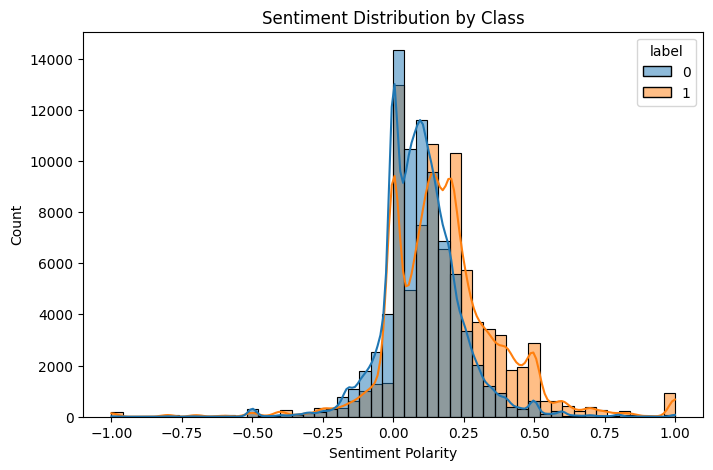

In [34]:
df_emails['sentiment'] = df_emails['clean_body'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(8,5))
sns.histplot(data=df_emails, x='sentiment', hue='label', bins=50, kde=True)
plt.title("Sentiment Distribution by Class")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Count")
plt.show()

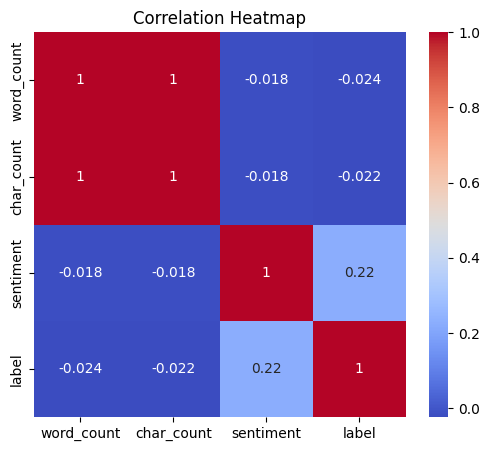

In [35]:
# Feature correlation
df_features = df_emails[['word_count','char_count','sentiment','label']]
plt.figure(figsize=(6,5))
sns.heatmap(df_features.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

HERE WE CAN PUT A BREAK AND TELL THE PROFESSOR WE DID EXTRA ANALYSIS ON ASPECTSOF THESE EMAILS THAT CAN AFFECT OUR NEXT MODEL THAT WE WILL BUILD, THE BERT MODEL.

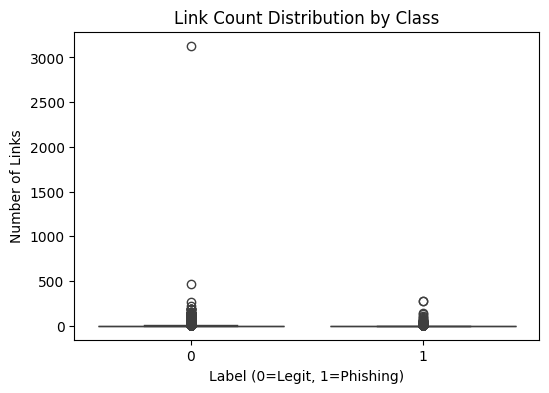

In [ ]:
df_emails['link_count'] = df_emails['body'].str.count(r'http')
plt.figure(figsize=(6,4))
sns.boxplot(x='label', y='link_count', data=df_emails)
plt.title("Link Count Distribution by Class")
plt.xlabel("Label (0=Legit, 1=Phishing)")
plt.ylabel("Number of Links")
plt.show()

# Insight: Phishing emails often include slightly more links than legit ones, but extreme high-link outliers mostly come from legitimate bulk emails.

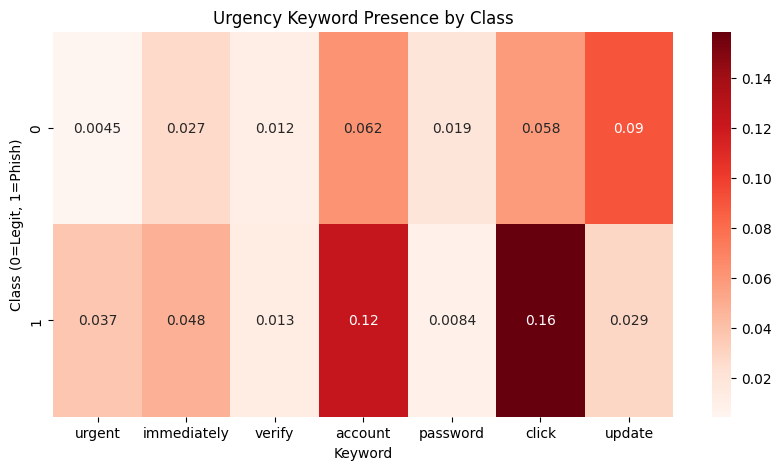

In [ ]:
urgency_words = ["urgent","immediately","verify","account","password","click","update"]
urgency_matrix = pd.DataFrame({word: df_emails['clean_body'].str.contains(word, case=False).astype(int)
                               for word in urgency_words})
urgency_matrix['label'] = df_emails['label']
plt.figure(figsize=(10,5))
sns.heatmap(urgency_matrix.groupby('label').mean(), annot=True, cmap="Reds")
plt.title("Urgency Keyword Presence by Class")
plt.xlabel("Keyword")
plt.ylabel("Class (0=Legit, 1=Phish)")
plt.show()

# Insight: Phishing emails show a much higher presence of urgency-related keywords—especially “click,” “account,” and “urgent”—compared to legitimate emails, confirming that urgency is a strong phishing signal.


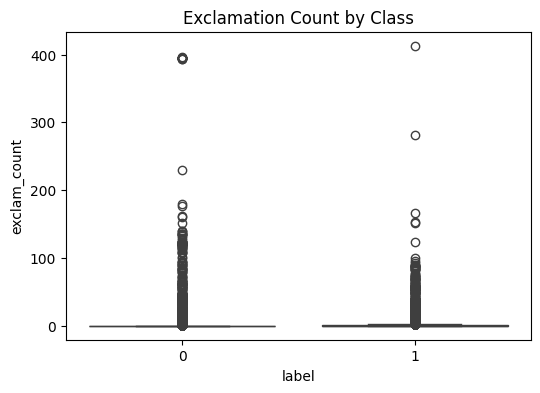

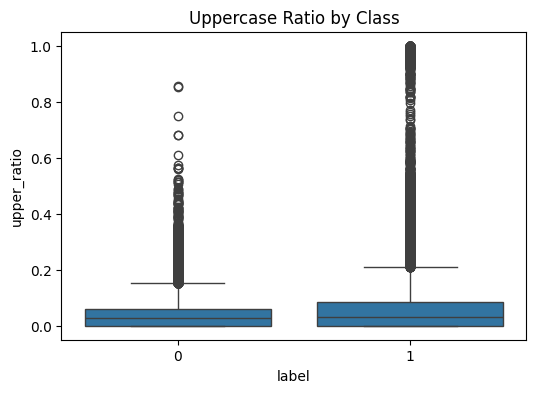

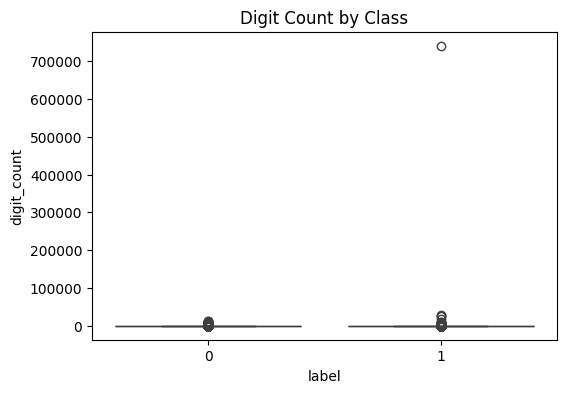

      exclam_count                                          upper_ratio  \
             count   mean    std  min  25%  50%  75%    max       count   
label                                                                     
0          39595.0  1.031  9.094  0.0  0.0  0.0  0.0  396.0     39595.0   
1          42890.0  1.401  4.871  0.0  0.0  0.0  1.0  413.0     42890.0   

              ...               digit_count                                    \
        mean  ...    75%    max       count    mean       std  min  25%   50%   
label         ...                                                               
0      0.039  ...  0.060  0.854     39595.0  72.224   346.228  0.0  9.0  24.0   
1      0.072  ...  0.084  1.000     42890.0  56.296  3587.072  0.0  0.0   6.0   

                       
        75%       max  
label                  
0      53.0   11454.0  
1      26.0  740710.0  

[2 rows x 24 columns]


In [ ]:
# Exclamations / uppercase / digits per email
df_emails['exclam_count'] = df_emails['body'].str.count(r'!')
df_emails['upper_ratio']  = df_emails['body'].apply(lambda s: (sum(ch.isupper() for ch in s if ch.isalpha()) /
                                                               max(1, sum(ch.isalpha() for ch in s))))
df_emails['digit_count']  = df_emails['body'].str.count(r'\d')

# Boxplots by class
plt.figure(figsize=(6,4)); sns.boxplot(x='label', y='exclam_count', data=df_emails); plt.title("Exclamation Count by Class"); plt.show()
plt.figure(figsize=(6,4)); sns.boxplot(x='label', y='upper_ratio',  data=df_emails); plt.title("Uppercase Ratio by Class");   plt.show()
plt.figure(figsize=(6,4)); sns.boxplot(x='label', y='digit_count',  data=df_emails); plt.title("Digit Count by Class");       plt.show()

# Classwise summary table
print(df_emails.groupby('label')[['exclam_count','upper_ratio','digit_count']].describe().round(3))


# Insight: Phishing emails tend to use slightly more exclamation marks and uppercase text, signaling urgency, and often include numeric strings (IDs, order numbers) to appear credible. 
# Legitimate emails show greater variability, with outliers coming from automated system messages or bulk notifications.

,term,weight,direction
0,http,6.262273,phish
1,love,5.841868,phish
2,account,5.703105,phish
3,life,5.403055,phish
4,click,5.116697,phish
5,money,4.697295,phish
6,watches,4.542708,phish
7,replica,3.929288,phish
8,site,3.748021,phish
9,investment,3.673373,phish


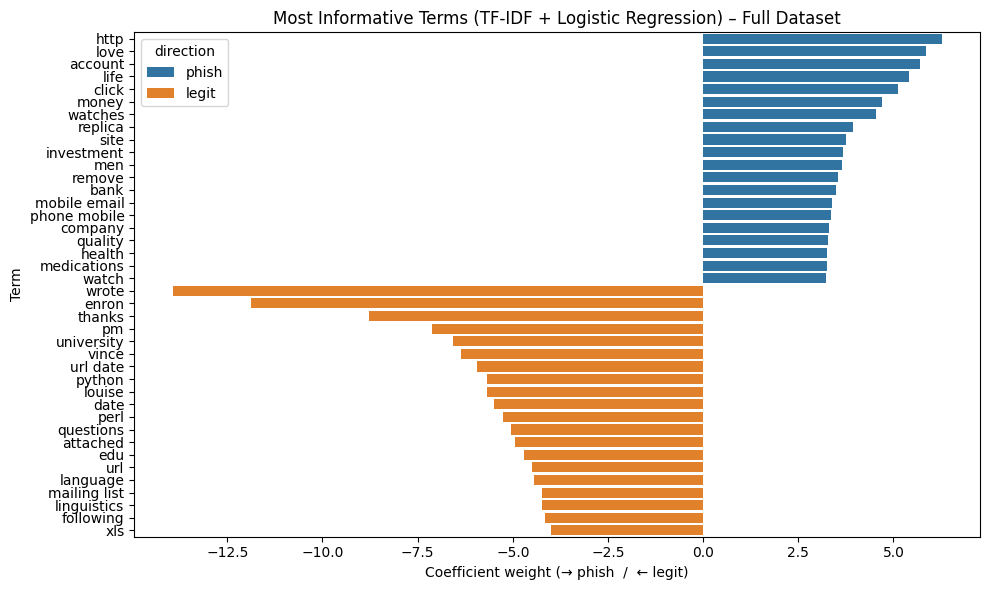

In [ ]:
from sklearn.linear_model import LogisticRegression

# ===== TF-IDF + Logistic Regression on the FULL DATASET (no sampling) =====
# Uses all rows in df_emails['clean_body'] and df_emails['label']

# Vectorize the whole corpus (1–2 grams). Tune max_features/min_df if memory gets tight.
vec = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 2),
    max_features=80000,   # raise/lower as your RAM allows (e.g., 120_000 or 50_000)
    min_df=5,             # ignore very rare terms to reduce noise & size
    max_df=0.90           # drop super common terms
)
X = vec.fit_transform(df_emails['clean_body'])
X = X.astype('float32')   # shrink memory footprint
y = df_emails['label'].astype(int).values

# Logistic Regression on full sparse matrix
# 'saga' handles large, sparse problems; class_weight balances classes if needed
clf = LogisticRegression(
    max_iter=1000,
    solver='saga',
    n_jobs=-1,
    class_weight='balanced',
    penalty='l2',
    C=1.0
)
clf.fit(X, y)

# Most informative terms
feat_names = np.array(vec.get_feature_names_out())
coef = clf.coef_[0]
top_phish = np.argsort(coef)[-20:][::-1]
top_ham   = np.argsort(coef)[:20]

top_terms = pd.DataFrame({
    'term': np.r_[feat_names[top_phish], feat_names[top_ham]],
    'weight': np.r_[coef[top_phish],     coef[top_ham]],
    'direction': ['phish']*len(top_phish) + ['legit']*len(top_ham)
})
display(top_terms)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_terms, x='weight', y='term', hue='direction')
plt.title("Most Informative Terms (TF-IDF + Logistic Regression) – Full Dataset")
plt.xlabel("Coefficient weight (→ phish  /  ← legit)")
plt.ylabel("Term")
plt.tight_layout()
plt.show()


# Insight: The logistic regression model highlights terms like “http,” “account,” “click,” and “money” as strongly associated with phishing emails, 
# while words such as “thanks,” “university,” and “attached” are more typical of legitimate messages. This confirms that phishing language is action- and urgency-oriented, 
# while legitimate emails focus on communication and context.


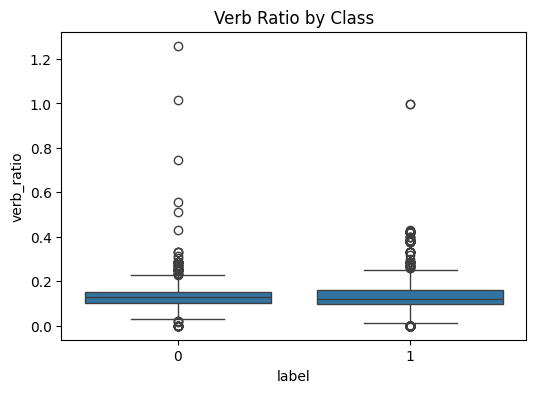

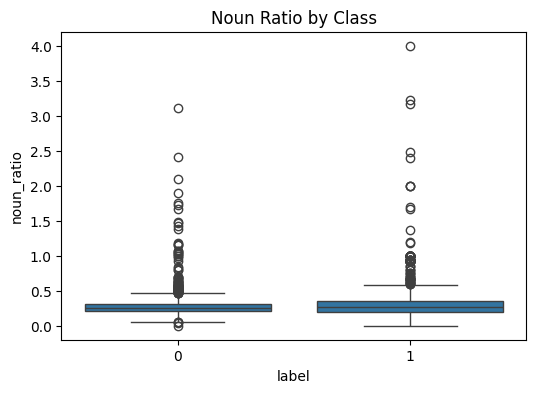

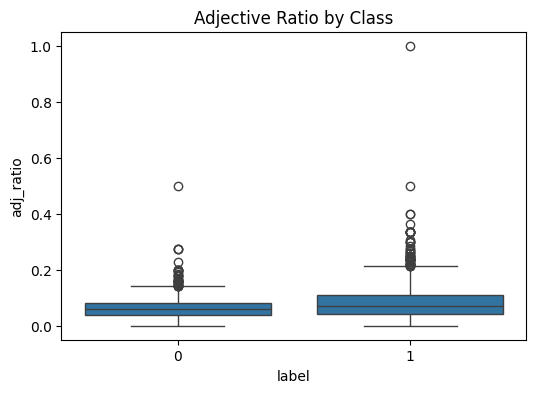

       verb_ratio  noun_ratio  adj_ratio
label                                   
0           0.131       0.281      0.062
1           0.142       0.339      0.081


In [ ]:
def pos_ratios(text):
    doc = nlp(text[:5000])  # cap length for speed
    total = max(1, len([t for t in doc if t.is_alpha]))
    verbs = sum(1 for t in doc if t.pos_ == "VERB")
    nouns = sum(1 for t in doc if t.pos_ == "NOUN")
    adjs  = sum(1 for t in doc if t.pos_ == "ADJ")
    return pd.Series({'verb_ratio': verbs/total, 'noun_ratio': nouns/total, 'adj_ratio': adjs/total})

pos_df = df_emails['body'].sample(min(4000, len(df_emails)), random_state=42).apply(pos_ratios)
pos_df['label'] = df_emails.loc[pos_df.index, 'label'].values

plt.figure(figsize=(6,4)); sns.boxplot(x='label', y='verb_ratio', data=pos_df); plt.title("Verb Ratio by Class"); plt.show()
plt.figure(figsize=(6,4)); sns.boxplot(x='label', y='noun_ratio', data=pos_df); plt.title("Noun Ratio by Class"); plt.show()
plt.figure(figsize=(6,4)); sns.boxplot(x='label', y='adj_ratio',  data=pos_df); plt.title("Adjective Ratio by Class"); plt.show()

print(pos_df.groupby('label')[['verb_ratio','noun_ratio','adj_ratio']].mean().round(3))

# Insight: Phishing emails use a slightly higher share of verbs and adjectives than legit messages (more action-oriented, persuasive language), 
# while noun ratios are similar. This supports the idea that phishing pushes recipients to act (“verify,” “update,” etc.) rather than just inform.


,ORG,MONEY,DATE,PERSON
label,,,,
0,3.477,0.392,3.170,4.807
1,2.379,0.700,1.294,2.111


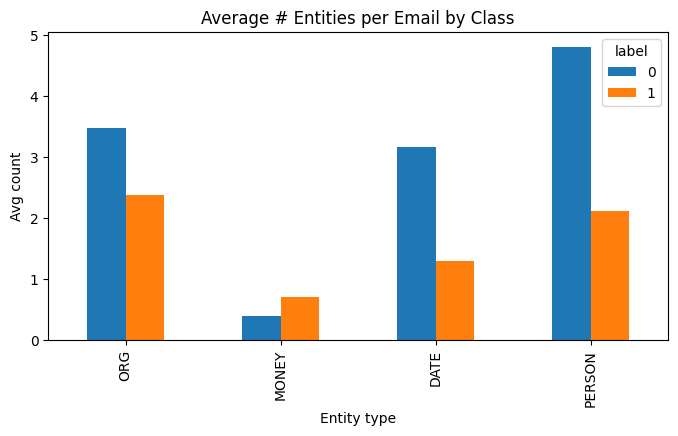

In [ ]:
ent_labels = ['ORG','MONEY','DATE','PERSON']
def ent_counts(text):
    doc = nlp(text[:4000])
    c = Counter([e.label_ for e in doc.ents if e.label_ in ent_labels])
    return pd.Series({lab: c.get(lab,0) for lab in ent_labels})

ents = df_emails['body'].sample(min(3000, len(df_emails)), random_state=42).apply(ent_counts)
ents['label'] = df_emails.loc[ents.index,'label'].values

mean_ents = ents.groupby('label')[ent_labels].mean().round(3)
display(mean_ents)

mean_ents.T.plot(kind='bar', figsize=(8,4)); plt.title("Average # Entities per Email by Class"); plt.ylabel("Avg count"); plt.xlabel("Entity type"); plt.show()

# Insight: Legitimate emails mention organizations, people, and dates far more often (e.g., meeting invites, reports), while phishing emails mention money and
#  financial terms more frequently. This supports the idea that phishing emails focus on payment or account-related issues, whereas legitimate ones include more real-world references and context.

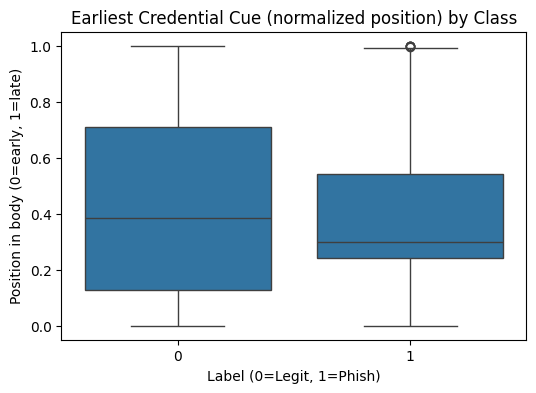

In [ ]:
def earliest_pos(text, phrase_list):
    t = text.lower()
    L = len(t)
    idx = min([t.find(p) for p in phrase_list if t.find(p) != -1], default=-1)
    return np.nan if idx == -1 else idx / max(1, L)

CREDENTIAL = ["login","log in","sign in","password","verify","reset","confirm","update"]
df_emails['earliest_cred_norm'] = df_emails['body'].apply(lambda s: earliest_pos(s, CREDENTIAL))

plt.figure(figsize=(6,4))
sns.boxplot(x='label', y='earliest_cred_norm', data=df_emails)
plt.title("Earliest Credential Cue (normalized position) by Class")
plt.ylabel("Position in body (0=early, 1=late)"); plt.xlabel("Label (0=Legit, 1=Phish)")
plt.show()

# Insight: Phishing emails tend to mention credential-related terms (like login, password, verify) earlier in the message body than 
# legitimate emails. This supports the idea that phishing emails try to grab attention quickly and prompt immediate action, whereas legitimate 
# emails often provide context first before mentioning credentials.